In [2]:
#imports
import gdown
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
url = "https://drive.google.com/drive/folders/1aulFmTOH2YDHAUsclBRdcEQCgxslKbh2"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/9417_data/X_test.npy',
 '/content/9417_data/X_train.npy',
 '/content/9417_data/y_train.npy']

In [4]:
#read_data
x_test_path = '/content/9417_data/X_test.npy'
y_train_path = '/content/9417_data/y_train.npy'
x_train_path = '/content/9417_data/X_train.npy'

# Load the data
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_test = np.load(x_test_path)

In [5]:
def analyze_data(X_train, X_test, y_train):
    analysis = {
        "X_train_shape": X_train.shape,
        "X_test_shape": X_test.shape,
        "y_train_shape": y_train.shape,
        "X_train_missing_values": np.isnan(X_train).sum(),
        "X_test_missing_values": np.isnan(X_test).sum(),
        "y_train_missing_values": np.isnan(y_train).sum(),
    }
    return analysis

# Perform the analysis
analysis_result = analyze_data(X_train, X_test, y_train)
analysis_result

{'X_train_shape': (1000, 111),
 'X_test_shape': (700, 111),
 'y_train_shape': (1000, 11),
 'X_train_missing_values': 9450,
 'X_test_missing_values': 6524,
 'y_train_missing_values': 0}

In [6]:
#data cleaning using median for numerical features
#impute all missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_imputed_missing_values = np.isnan(X_train_imputed).sum()
X_test_imputed_missing_values = np.isnan(X_test_imputed).sum()

X_train_imputed_missing_values, X_test_imputed_missing_values

(0, 0)

In [7]:
#data cleaning using KNN for numerical features
# KNN Imputer initialization
knn_imputer = KNNImputer(n_neighbors=5)
# Impute missing values in X_train
X_train_imputed_knn = knn_imputer.fit_transform(X_train)
X_test_imputed_knn = knn_imputer.transform(X_test)
X_train_imputed_knn_missing_values = np.isnan(X_train_imputed_knn).sum()
X_test_imputed_knn_missing_values = np.isnan(X_test_imputed_knn).sum()

X_train_imputed_knn_missing_values, X_test_imputed_knn_missing_values

(0, 0)

*This* part is EDA analysis, responded by Andrew. also add extra data cleaning

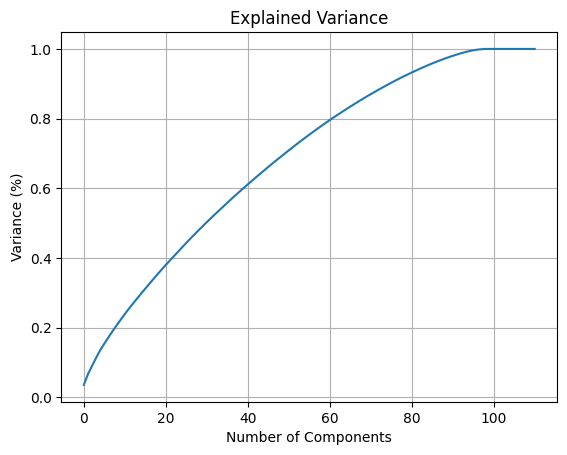

In [8]:
#For this case l will use KNN as pre_transformed data
# Standardize the data before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed_knn)
X_test_scaled = scaler.transform(X_test_imputed_knn)

# PCA Analysis
pca = PCA().fit(X_train_scaled)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.grid(True)
plt.show()

In [9]:
#report the PCA analysis as part of EDA analysis
pca_initial = PCA()
X_train_pca_initial = pca_initial.fit_transform(X_train_scaled)
explained_variance_ratio = pca_initial.explained_variance_ratio_
explained_var_per = explained_variance_ratio * 100
explained_variance_sequence = sorted(list(explained_var_per), reverse=True)

near_zero_variance_threshold = 1e-5

near_zero_variances = [variance for variance in explained_variance_sequence if variance < near_zero_variance_threshold]

# Number of components to keep (those above the threshold)
n_components_to_keep = len(explained_variance_sequence) - len(near_zero_variances)

# Redefine PCA with the selected number of components
pca_reduced = PCA(n_components=n_components_to_keep)

# Apply PCA to the scaled data
X_train_pca_reduced = pca_reduced.fit_transform(X_train_scaled)

# Number of features before and after PCA
original_features = X_train_scaled.shape[1]
reduced_features = X_train_pca_reduced.shape[1]

#print all features that need to be removed
features_below_threshold_indices = [i for i, variance in enumerate(explained_variance_ratio) if variance * 100 < near_zero_variance_threshold]

# Printing the indices of features with variance below the threshold
print(f"Features with variance below the threshold ({near_zero_variance_threshold}):")
for index in features_below_threshold_indices:
    print(f"feature_{index}")

# Now, perform the train-validation split on the PCA-reduced data
X_train_scaled_partition, X_val_scaled_partition, Y_train, Y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

Features with variance below the threshold (1e-05):
feature_99
feature_100
feature_101
feature_102
feature_103
feature_104
feature_105
feature_106
feature_107
feature_108
feature_109
feature_110


In [10]:
#using GB boosting classifier to find feature importance
from sklearn.ensemble import GradientBoostingClassifier

# Redefine the Gradient Boosting model
X_train_df = pd.DataFrame(X_train_scaled, columns=[f'feature_{i}' for i in range(X_train_scaled.shape[1])])
gbc = GradientBoostingClassifier(n_estimators=100, random_state=0)

gbc.fit(X_train_df, y_train.argmax(axis=1))

# Getting feature importances from the Gradient Boosting model
feature_importances = gbc.feature_importances_
# Output the feature importances
feature_importances_ordered = sorted(zip(X_train_df.columns, feature_importances), key=lambda x: x[1], reverse=True)
top_features = feature_importances_ordered[:10]  # Show top 10 features

top_features

[('feature_85', 0.06239067262750877),
 ('feature_86', 0.06147293437549107),
 ('feature_88', 0.061177489318850496),
 ('feature_83', 0.06115827992568629),
 ('feature_90', 0.054082389898570046),
 ('feature_89', 0.04821927654574657),
 ('feature_0', 0.04129966813025973),
 ('feature_35', 0.04068431711744673),
 ('feature_82', 0.031771195588773574),
 ('feature_33', 0.030890668349509803)]

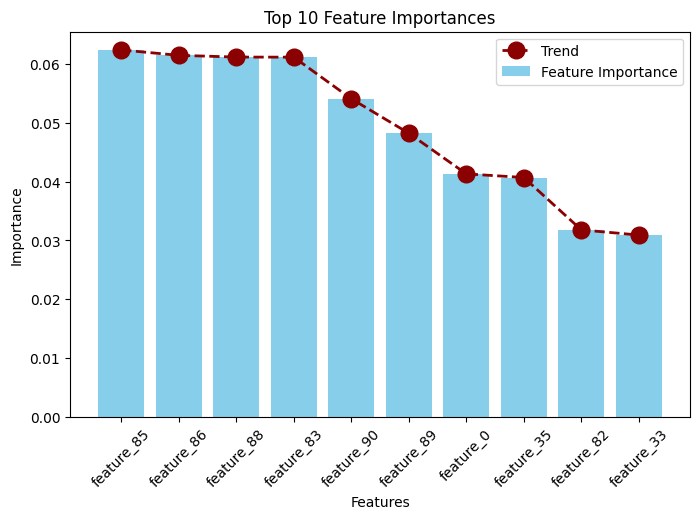

In [11]:
# Extracting features and their corresponding importance
features, importances = zip(*top_features)

# Plotting the feature importances
plt.figure(figsize=(8, 5))
plt.bar(features, importances, color='skyblue', label='Feature Importance')
plt.plot(features, importances, color='darkred', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Trend')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.xticks(rotation=45)
plt.legend()
plt.show()

unsupervised method(check data ifself, no prediction):
PCA Explained Variance: PCA looks at the variance in the data. We refer to how much of the total dataset variance is captured by that principal component.  

supervised method(need involve y_train)
Gradient Boosting Feature Importance: This indicates how valuable each feature was in the construction of the boosted decision trees within the model. It's based on how much each feature contributes to decreasing the model's error.

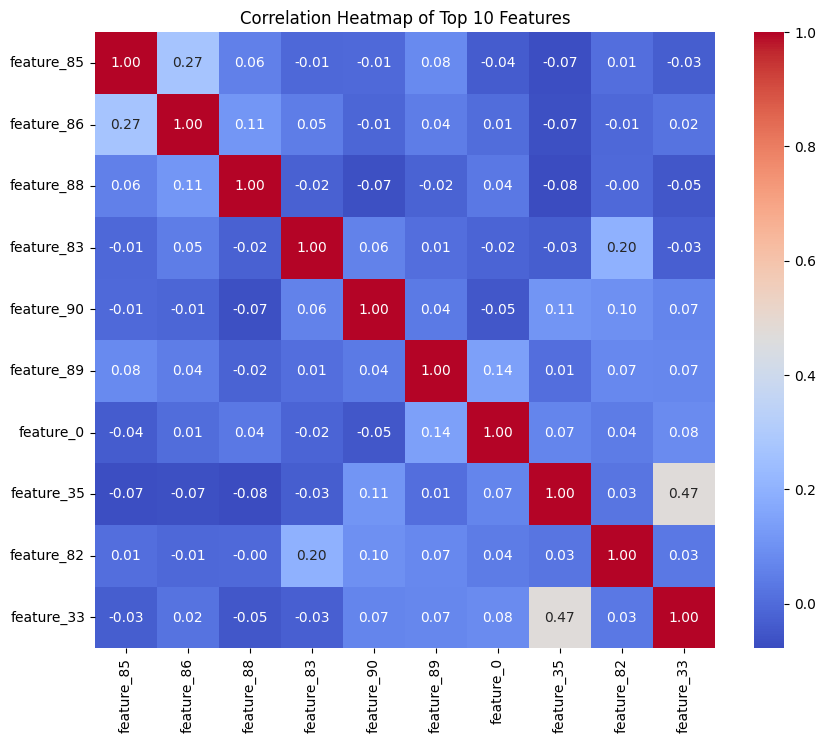

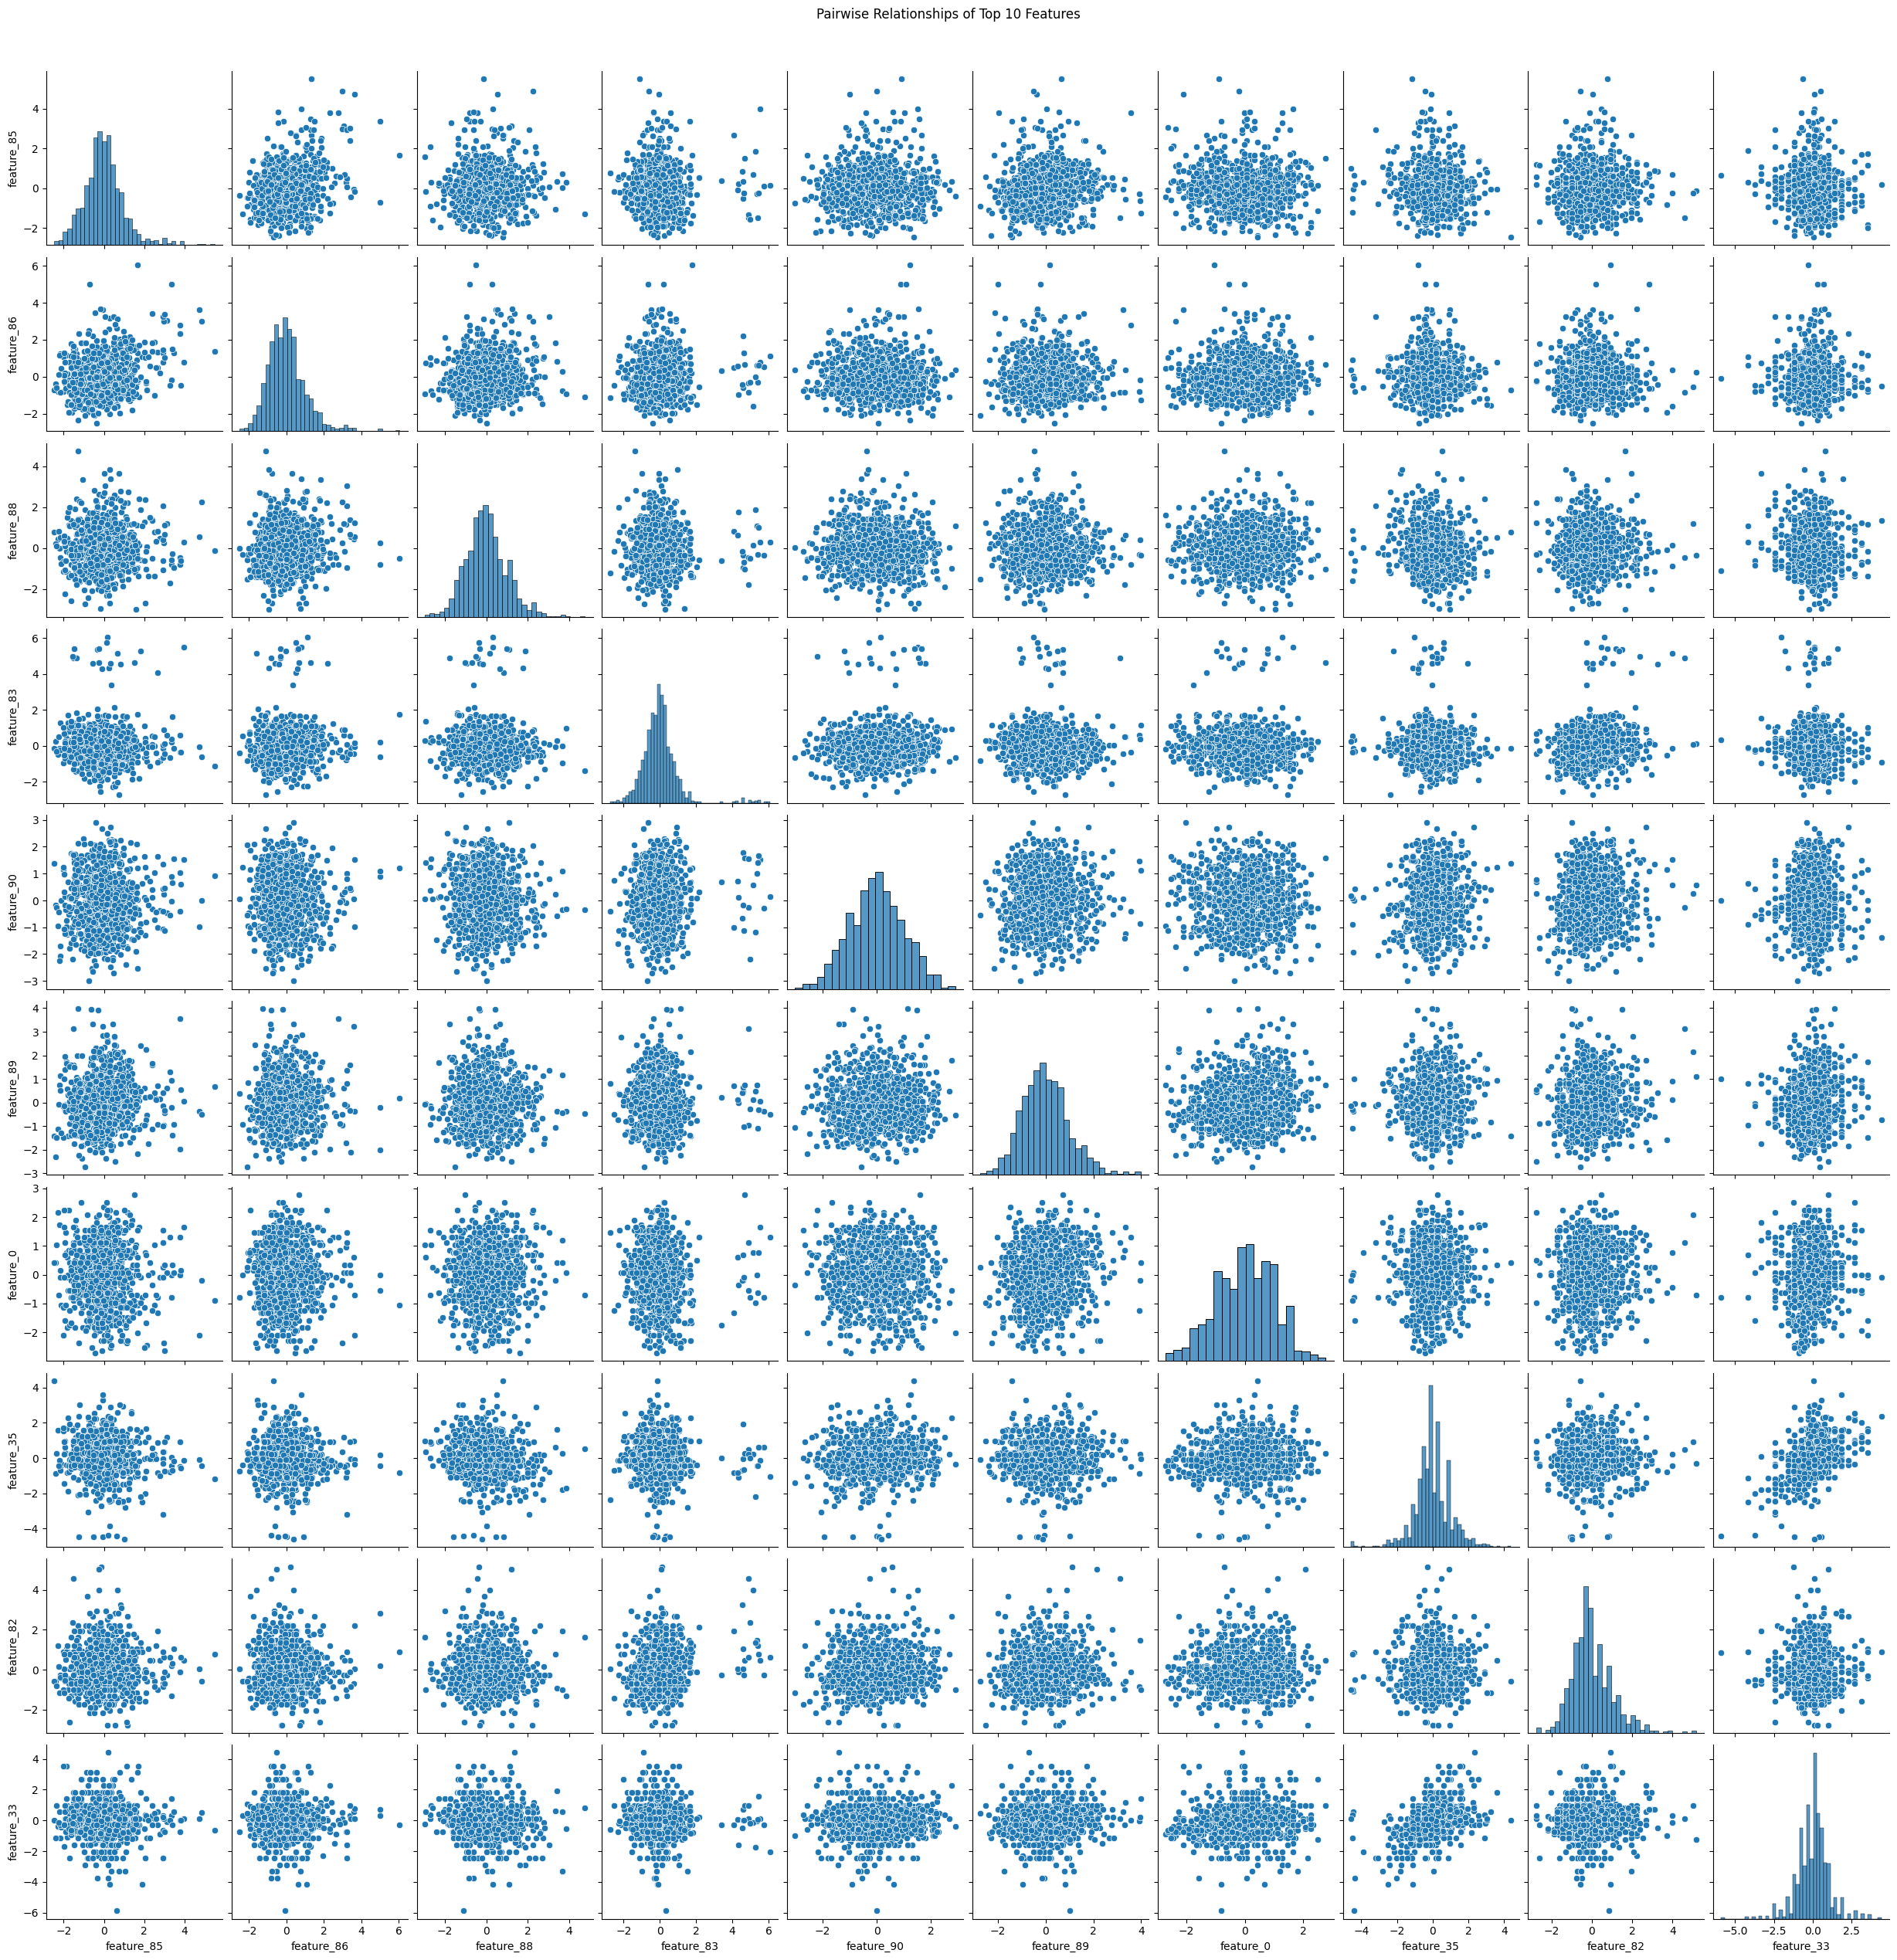

In [12]:
import seaborn as sns
# Correlation matrix of the top 10 features
top_10_features_names = [name for name, _ in top_features]
# Creating a DataFrame with only the top 10 features
X_top_10_features = X_train_df[top_10_features_names]
corr_matrix_top_10 = X_top_10_features.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_top_10, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Top 10 Features')
plt.show()

# Plotting the pairplots for the top 10 features
sns.pairplot(X_top_10_features)
plt.suptitle('Pairwise Relationships of Top 10 Features', y=1.02)  # Adjust title position
plt.show()

from here we can find that the features we picked using GBC are all weak correlated to each other, we can keep them all.

This visualization helps identify patterns, trends, and potential outliers across different feature combinations. The diagonal shows the distribution of each feature, providing insight into skewness or multimodality.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-13-b2434dc9b838>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top_10_features['cluster'] = kmeans.labels_


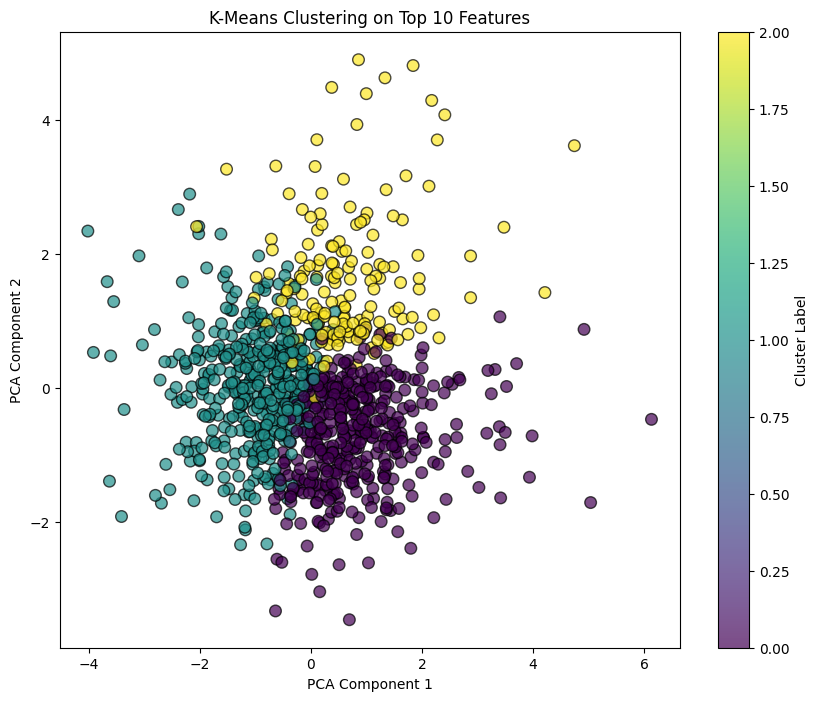

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_top_10_features)
X_top_10_features['cluster'] = kmeans.labels_
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_top_10_features.drop('cluster', axis=1))

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=X_top_10_features['cluster'], cmap='viridis', marker='o', edgecolor='k', s=70, alpha=0.7)
plt.title('K-Means Clustering on Top 10 Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

The purple cluster is centered around the origin of the PCA component axes  suggest that these data points have less variation.

The yellow cluster is the most dispersed and seems to be spread along the PCA Component 1 axis. The dispersion suggests this group is quite heterogeneous compared to the other clusters, or it may contain outliers. But l still prefer to keep all the data even they might contains outliers

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, hamming_loss, log_loss

#use rf
# Initialize Classifier Chain with a base estimator
base_estimator = RandomForestClassifier()
chain_clf = ClassifierChain(base_estimator, order='random', random_state=0)

# Hyperparameter tuning
param_grid = {
    'base_estimator__n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [10, 20, None]
}
grid_search = GridSearchCV(chain_clf, param_grid, cv=5, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

# Fit the model on the scaled data, not the PCA-transformed data
grid_search.fit(X_train_scaled_partition, Y_train)

# Evaluate the model using the scaled validation data
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val_scaled_partition)
y_val_pred = best_model.predict(X_val_scaled_partition)

# Calculate the log_loss for each label and then take the average
average_log_loss = np.mean([log_loss(Y_val[:, i], y_pred_proba[:, i]) for i in range(Y_val.shape[1])])
hamming = hamming_loss(Y_val, y_val_pred)
hamming_score = 1 - hamming
print("Hamming Score:", hamming_score)
print("Average Binary Cross-Entropy Loss:", average_log_loss)


Hamming Score: 0.7504545454545455
Average Binary Cross-Entropy Loss: 0.5587737671661757


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression

# Initialize Classifier Chain with Logistic Regression as the base estimator
base_estimator = LogisticRegression(solver='liblinear')
chain_clf = ClassifierChain(base_estimator, order='random', random_state=0)

# Hyperparameter tuning
param_grid = {
    'base_estimator__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'base_estimator__penalty': ['l1', 'l2']  # Norm used in penalization
}
grid_search = GridSearchCV(chain_clf, param_grid, cv=5, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

# Fit the model on the scaled data, not the PCA-transformed data
grid_search.fit(X_train_scaled_partition, Y_train)

# After fitting, the best model and parameters can be selected
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val_scaled_partition)

# Calculate the log_loss for each label and then take the average
average_log_loss2 = np.mean([log_loss(Y_val[:, i], y_pred_proba[:, i]) for i in range(Y_val.shape[1])])

print("Average Binary Cross-Entropy Loss:", average_log_loss2)


Average Binary Cross-Entropy Loss: 0.5973652112541127


In [16]:
#new LDA method
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, hamming_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
import numpy as np

x_test_path = '/content/9417_data/X_test.npy'
y_train_path = '/content/9417_data/y_train.npy'
x_train_path = '/content/9417_data/X_train.npy'

# Load the data
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_test = np.load(x_test_path)

knn_imputer = KNNImputer(n_neighbors=5)
# Impute missing values in X_train
X_train_imputed_knn = knn_imputer.fit_transform(X_train)
X_test_imputed_knn = knn_imputer.transform(X_test)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed_knn)
X_test_scaled = scaler.transform(X_test_imputed_knn)

y_train_single = LabelEncoder().fit_transform([''.join(str(label)) for label in y_train])

# Apply LDA for dimensionality reduction
lda = LDA(n_components=1)  # n_components should be < min(n_classes - 1, n_features)
X_train_lda = lda.fit_transform(X_train_scaled, y_train_single)

lda_coefficients = np.abs(lda.coef_[0])

# Get the top features based on the LDA coefficients
top_features = np.argsort(lda_coefficients)[-10:]  # Adjust the number based on how many top features you want

X_train_scaled_partition, X_val_scaled_partition, Y_train, Y_val = train_test_split(
    X_train_lda, y_train, test_size=0.2, random_state=42)

base_estimator = RandomForestClassifier()
chain_clf = ClassifierChain(base_estimator, order='random', random_state=0)

# Hyperparameter tuning
param_grid = {
    'base_estimator__n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [10, 20, None]
}
grid_search = GridSearchCV(chain_clf, param_grid, cv=5, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

# Fit the model on the scaled data, not the PCA-transformed data
grid_search.fit(X_train_scaled_partition, Y_train)

# Evaluate the model using the scaled validation data
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val_scaled_partition)
y_val_pred = best_model.predict(X_val_scaled_partition)

# Calculate the log_loss for each label and then take the average
average_log_loss = np.mean([log_loss(Y_val[:, i], y_pred_proba[:, i]) for i in range(Y_val.shape[1])])
hamming = hamming_loss(Y_val, y_val_pred)
hamming_score = 1 - hamming
print("Hamming Score:", hamming_score)
print("Average Binary Cross-Entropy Loss:", average_log_loss)

Hamming Score: 0.7504545454545455
Average Binary Cross-Entropy Loss: 0.556564998826962


In [17]:
#new LDA method
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, hamming_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
import numpy as np
from xgboost import XGBClassifier

x_test_path = '/content/9417_data/X_test.npy'
y_train_path = '/content/9417_data/y_train.npy'
x_train_path = '/content/9417_data/X_train.npy'

# Load the data
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_test = np.load(x_test_path)

knn_imputer = KNNImputer(n_neighbors=5)
# Impute missing values in X_train
X_train_imputed_knn = knn_imputer.fit_transform(X_train)
X_test_imputed_knn = knn_imputer.transform(X_test)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed_knn)
X_test_scaled = scaler.transform(X_test_imputed_knn)

y_train_single = LabelEncoder().fit_transform([''.join(str(label)) for label in y_train])

# Apply LDA for dimensionality reduction
lda = LDA(n_components=1)  # n_components should be < min(n_classes - 1, n_features)
X_train_lda = lda.fit_transform(X_train_scaled, y_train_single)

lda_coefficients = np.abs(lda.coef_[0])

# Get the top features based on the LDA coefficients
top_features = np.argsort(lda_coefficients)[-10:]  # Adjust the number based on how many top features you want

X_train_scaled_partition, X_val_scaled_partition, Y_train, Y_val = train_test_split(
    X_train_lda, y_train, test_size=0.2, random_state=42)

base_estimator = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
chain_clf_xgb = ClassifierChain(base_estimator, order='random', random_state=0)

param_grid_xgb = {
    'base_estimator__n_estimators': [100, 200],
    'base_estimator__max_depth': [6, 10, None],
    'base_estimator__learning_rate': [0.01, 0.1]
}

grid_search_xgb = GridSearchCV(chain_clf_xgb, param_grid_xgb, cv=5, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))
grid_search_xgb.fit(X_train_scaled_partition, Y_train)

best_model_xgb = grid_search_xgb.best_estimator_
y_pred_proba_xgb = best_model_xgb.predict_proba(X_val_scaled_partition)
y_val_pred_xgb = best_model_xgb.predict(X_val_scaled_partition)

average_log_loss_xgb = np.mean([log_loss(Y_val[:, i], y_pred_proba_xgb[:, i]) for i in range(Y_val.shape[1])])
hamming_xgb = hamming_loss(Y_val, y_val_pred_xgb)
hamming_score_xgb = 1 - hamming_xgb

print("XGBoost Hamming Score:", hamming_score_xgb)
print("XGBoost Average Binary Cross-Entropy Loss:", average_log_loss_xgb)

XGBoost Hamming Score: 0.7504545454545455
XGBoost Average Binary Cross-Entropy Loss: 0.5564254749059021


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import log_loss


x_test_path = '/content/9417_data/X_test.npy'
y_train_path = '/content/9417_data/y_train.npy'
x_train_path = '/content/9417_data/X_train.npy'

# Load the data
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_test = np.load(x_test_path)

knn_imputer = KNNImputer(n_neighbors=5)
# Impute missing values in X_train
X_train_imputed = knn_imputer.fit_transform(X_train)
X_test_imputed = knn_imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

X_train_scaled_partition, X_val_scaled_partition, Y_train, Y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42)

X_train_reshaped = X_train_scaled_partition.reshape((X_train_scaled_partition.shape[0], X_train_scaled_partition.shape[1], 1))
X_val_reshaped = X_val_scaled_partition.reshape((X_val_scaled_partition.shape[0], X_val_scaled_partition.shape[1], 1))

# CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# Define callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_reshaped, Y_train, epochs=100, batch_size=32, validation_data=(X_val_reshaped, Y_val), callbacks=[reduce_lr, early_stopping])

# Evaluate the model using the average binary cross-entropy loss
y_pred_proba = model.predict(X_val_reshaped)
average_log_loss = np.mean([log_loss(Y_val[:, i], y_pred_proba[:, i]) for i in range(Y_val.shape[1])])

print("Average Binary Cross-Entropy Loss:", average_log_loss)


Epoch 1/100
25/25 [==============================] - 1s 20ms/step - loss: 9.7236 - val_loss: 3.7829 - lr: 0.1000
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 2.3500 - val_loss: 1.4246 - lr: 0.1000
Epoch 3/100
25/25 [==============================] - 0s 13ms/step - loss: 1.1123 - val_loss: 0.7069 - lr: 0.1000
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 0.6605 - val_loss: 0.5828 - lr: 0.1000
Epoch 5/100
25/25 [==============================] - 0s 12ms/step - loss: 0.5825 - val_loss: 0.5606 - lr: 0.1000
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 0.5706 - val_loss: 0.5564 - lr: 0.1000
Epoch 7/100
25/25 [==============================] - 0s 18ms/step - loss: 0.5700 - val_loss: 0.5578 - lr: 0.1000
Epoch 8/100
25/25 [==============================] - 0s 17ms/step - loss: 0.5696 - val_loss: 0.5567 - lr: 0.1000
Epoch 9/100
25/25 [==============================] - 0s 17ms/step - loss: 0.5696 - val_loss: 0.5

In [19]:
from sklearn.cross_decomposition import CCA

x_test_path = '/content/9417_data/X_test.npy'
y_train_path = '/content/9417_data/y_train.npy'
x_train_path = '/content/9417_data/X_train.npy'

# Load the data
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_test = np.load(x_test_path)

knn_imputer = KNNImputer(n_neighbors=5)
# Impute missing values in X_train
X_train_imputed = knn_imputer.fit_transform(X_train)
X_test_imputed = knn_imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

transformed_features_list = []

# Perform CCA for each label separately
for i in range(y_train.shape[1]):  # For each label
    cca = CCA(n_components=1)  # Using 1 component for simplicity; adjust as needed
    # Fit CCA: Note, y_train[:, i:i+1] makes the label 2D which is expected by CCA
    cca.fit(X_train_scaled, y_train[:, i:i+1])
    # Transform the features and add them to the list
    X_c = cca.transform(X_train_scaled)
    transformed_features_list.append(X_c)

# Combine the transformed features from each label into a single feature set
X_transformed = np.hstack(transformed_features_list)

X_train_scaled_partition, X_val_scaled_partition, Y_train, Y_val = train_test_split(
    X_transformed, y_train, test_size=0.2, random_state=42)

base_estimator = RandomForestClassifier()
chain_clf = ClassifierChain(base_estimator, order='random', random_state=0)

# Hyperparameter tuning
param_grid = {
    'base_estimator__n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [10, 20, None]
}
grid_search = GridSearchCV(chain_clf, param_grid, cv=5, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

# Fit the model on the scaled data, not the PCA-transformed data
grid_search.fit(X_train_scaled_partition, Y_train)

# Evaluate the model using the scaled validation data
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val_scaled_partition)
y_val_pred = best_model.predict(X_val_scaled_partition)

# Calculate the log_loss for each label and then take the average
average_log_loss = np.mean([log_loss(Y_val[:, i], y_pred_proba[:, i]) for i in range(Y_val.shape[1])])
hamming = hamming_loss(Y_val, y_val_pred)
hamming_score = 1 - hamming
print("Hamming Score:", hamming_score)
print("Average Binary Cross-Entropy Loss:", average_log_loss)


Hamming Score: 0.7540909090909091
Average Binary Cross-Entropy Loss: 0.5279147993684418


In [20]:
from sklearn.cross_decomposition import CCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, log_loss, hamming_loss
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import numpy as np

x_test_path = '/content/9417_data/X_test.npy'
y_train_path = '/content/9417_data/y_train.npy'
x_train_path = '/content/9417_data/X_train.npy'

# Load the data
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_test = np.load(x_test_path)

knn_imputer = KNNImputer(n_neighbors=5)
# Impute missing values in X_train
X_train_imputed = knn_imputer.fit_transform(X_train)
X_test_imputed = knn_imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


transformed_features_list = []

# Perform CCA for each label separately
for i in range(y_train.shape[1]):  # For each label
    cca = CCA(n_components=1)  # Using 1 component for simplicity; adjust as needed
    # Fit CCA: Note, y_train[:, i:i+1] makes the label 2D which is expected by CCA
    cca.fit(X_train_scaled, y_train[:, i:i+1])
    # Transform the features and add them to the list
    X_c = cca.transform(X_train_scaled)
    transformed_features_list.append(X_c)

# Combine the transformed features from each label into a single feature set
X_transformed = np.hstack(transformed_features_list)

X_train_scaled_partition, X_val_scaled_partition, Y_train, Y_val = train_test_split(
    X_transformed, y_train, test_size=0.2, random_state=42)

base_estimator = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
chain_clf_xgb = ClassifierChain(base_estimator, order='random', random_state=0)

param_grid_xgb = {
    'base_estimator__n_estimators': [100, 200],
    'base_estimator__max_depth': [6, 10, None],
    'base_estimator__learning_rate': [0.01, 0.1]
}

grid_search_xgb = GridSearchCV(chain_clf_xgb, param_grid_xgb, cv=5, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))
grid_search_xgb.fit(X_train_scaled_partition, Y_train)

best_model_xgb = grid_search_xgb.best_estimator_
y_pred_proba_xgb = best_model_xgb.predict_proba(X_val_scaled_partition)
y_val_pred_xgb = best_model_xgb.predict(X_val_scaled_partition)

average_log_loss_xgb = np.mean([log_loss(Y_val[:, i], y_pred_proba_xgb[:, i]) for i in range(Y_val.shape[1])])
hamming_xgb = hamming_loss(Y_val, y_val_pred_xgb)
hamming_score_xgb = 1 - hamming_xgb

print("XGBoost Hamming Score:", hamming_score_xgb)
print("XGBoost Average Binary Cross-Entropy Loss:", average_log_loss_xgb)

XGBoost Hamming Score: 0.7522727272727272
XGBoost Average Binary Cross-Entropy Loss: 0.5246031281848567


In [41]:
from tensorflow.keras.models import Sequential
from sklearn.metrics import hamming_loss
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import keras

x_test_path = '/content/9417_data/X_test.npy'
y_train_path = '/content/9417_data/y_train.npy'
x_train_path = '/content/9417_data/X_train.npy'

# Load the data
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_test = np.load(x_test_path)

knn_imputer = KNNImputer(n_neighbors=5)
# Impute missing values in X_train
X_train_imputed = knn_imputer.fit_transform(X_train)
X_test_imputed = knn_imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

transformed_features_list = []

# Perform CCA for each label separately
for i in range(y_train.shape[1]):  # For each label
    cca = CCA(n_components=1)  # Using 1 component for simplicity; adjust as needed
    # Fit CCA: Note, y_train[:, i:i+1] makes the label 2D which is expected by CCA
    cca.fit(X_train_scaled, y_train[:, i:i+1])
    # Transform the features and add them to the list
    X_c = cca.transform(X_train_scaled)
    transformed_features_list.append(X_c)

# Combine the transformed features from each label into a single feature set
X_transformed = np.hstack(transformed_features_list)

X_train_scaled_partition, X_val_scaled_partition, Y_train, Y_val = train_test_split(
    X_transformed, y_train, test_size=0.2, random_state=42)

# Define the Neural Network architecture

def build_model(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(output_dim, activation='sigmoid')  # Assuming binary classification for each label
    ])
    return model

# Prepare the model
input_dim = X_train_scaled_partition.shape[1]
output_dim = Y_train.shape[1]  # Assuming y_train is not one-hot encoded
model = build_model(input_dim, output_dim)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train the model
model.fit(X_train_scaled_partition, Y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled_partition, Y_val), verbose=2)

y_pred_proba_nn = model.predict(X_val_scaled_partition)

threshold = 0.5
y_pred_nn = (y_pred_proba_nn > threshold).astype(int)
hamming_loss_nn = hamming_loss(Y_val, y_pred_nn)
hamming_score_nn = 1 - hamming_loss_nn

# Since we directly get probabilities, we can calculate log loss as follows
log_loss_nn = tf.keras.losses.binary_crossentropy(Y_val, y_pred_proba_nn)
average_log_loss_nn = np.mean(log_loss_nn)

print("Neural Network Hamming Score:", hamming_score_nn)
print("Neural Network Average Binary Cross-Entropy Loss:", average_log_loss_nn)

Epoch 1/100
25/25 - 2s - loss: 0.6722 - binary_accuracy: 0.5934 - val_loss: 0.6118 - val_binary_accuracy: 0.7441 - 2s/epoch - 95ms/step
Epoch 2/100
25/25 - 0s - loss: 0.6164 - binary_accuracy: 0.6974 - val_loss: 0.5688 - val_binary_accuracy: 0.7527 - 114ms/epoch - 5ms/step
Epoch 3/100
25/25 - 0s - loss: 0.5942 - binary_accuracy: 0.7230 - val_loss: 0.5546 - val_binary_accuracy: 0.7505 - 108ms/epoch - 4ms/step
Epoch 4/100
25/25 - 0s - loss: 0.5872 - binary_accuracy: 0.7309 - val_loss: 0.5491 - val_binary_accuracy: 0.7541 - 113ms/epoch - 5ms/step
Epoch 5/100
25/25 - 0s - loss: 0.5775 - binary_accuracy: 0.7325 - val_loss: 0.5451 - val_binary_accuracy: 0.7532 - 125ms/epoch - 5ms/step
Epoch 6/100
25/25 - 0s - loss: 0.5699 - binary_accuracy: 0.7343 - val_loss: 0.5416 - val_binary_accuracy: 0.7527 - 110ms/epoch - 4ms/step
Epoch 7/100
25/25 - 0s - loss: 0.5710 - binary_accuracy: 0.7349 - val_loss: 0.5389 - val_binary_accuracy: 0.7527 - 107ms/epoch - 4ms/step
Epoch 8/100
25/25 - 0s - loss: 0.564

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cross_decomposition import CCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from sklearn.metrics import hamming_loss
from tensorflow.keras.losses import binary_crossentropy

# Load the data (assuming you have your paths set up)
x_test_path = '/content/9417_data/X_test.npy'
y_train_path = '/content/9417_data/y_train.npy'
x_train_path = '/content/9417_data/X_train.npy'

# Load the data
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_test = np.load(x_test_path)

# Preprocessing
knn_imputer = KNNImputer(n_neighbors=5)
X_train_imputed = knn_imputer.fit_transform(X_train)
X_test_imputed = knn_imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


transformed_features_list = []

# Perform CCA for each label separately
for i in range(y_train.shape[1]):  # For each label
    cca = CCA(n_components=1)  # Using 1 component for simplicity; adjust as needed
    # Fit CCA: Note, y_train[:, i:i+1] makes the label 2D which is expected by CCA
    cca.fit(X_train_scaled, y_train[:, i:i+1])
    # Transform the features and add them to the list
    X_c = cca.transform(X_train_scaled)
    transformed_features_list.append(X_c)

# Combine the transformed features from each label into a single feature set
X_transformed = np.hstack(transformed_features_list)

X_train_scaled_partition, X_val_scaled_partition, Y_train, Y_val = train_test_split(
    X_transformed, y_train, test_size=0.2, random_state=42)


# Defining the hypermodel
class HyperModel(HyperModel):
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

    def build(self, hp):
        model = Sequential([
            Input(shape=(self.input_dim,)),
            Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                  activation='relu'),
            Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
            Dense(units=hp.Choice('units_layer_2', values=[32, 64, 128, 256]),
                  activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])),
            Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)),
            Dense(self.output_dim, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
        return model

# Splitting the dataset
X_train_scaled_partition, X_val_scaled_partition, Y_train, Y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42)

# Instantiating and running the tuner
tuner = RandomSearch(
    HyperModel(input_dim=X_train_scaled_partition.shape[1], output_dim=Y_train.shape[1]),
    objective='val_binary_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo'
)

tuner.search(X_train_scaled_partition, Y_train, epochs=100, validation_data=(X_val_scaled_partition, Y_val))

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Final training
best_model.fit(X_train_scaled_partition, Y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled_partition, Y_val), verbose=2)

# Predictions and evaluation
y_pred_proba = best_model.predict(X_val_scaled_partition)
y_pred = (y_pred_proba > 0.5).astype(int)
hamming_loss_value = hamming_loss(Y_val, y_pred)
hamming_score_nn = 1 - hamming_loss_nn

log_loss_nn = tf.keras.losses.binary_crossentropy(Y_val, y_pred_proba_nn)
average_log_loss_nn = np.mean(log_loss_nn)

print("Neural Network Hamming Score:", hamming_score_nn)
print("Neural Network Average Binary Cross-Entropy Loss:", average_log_loss_nn)


Trial 10 Complete [00h 00m 14s]
val_binary_accuracy: 0.7522727251052856

Best val_binary_accuracy So Far: 0.7522727251052856
Total elapsed time: 00h 02m 45s
Epoch 1/100
25/25 - 1s - loss: 0.5646 - binary_accuracy: 0.7400 - val_loss: 0.5613 - val_binary_accuracy: 0.7505 - 981ms/epoch - 39ms/step
Epoch 2/100
25/25 - 0s - loss: 0.5512 - binary_accuracy: 0.7411 - val_loss: 0.5602 - val_binary_accuracy: 0.7500 - 102ms/epoch - 4ms/step
Epoch 3/100
25/25 - 0s - loss: 0.5399 - binary_accuracy: 0.7464 - val_loss: 0.5608 - val_binary_accuracy: 0.7500 - 85ms/epoch - 3ms/step
Epoch 4/100
25/25 - 0s - loss: 0.5306 - binary_accuracy: 0.7470 - val_loss: 0.5617 - val_binary_accuracy: 0.7482 - 88ms/epoch - 4ms/step
Epoch 5/100
25/25 - 0s - loss: 0.5182 - binary_accuracy: 0.7553 - val_loss: 0.5657 - val_binary_accuracy: 0.7477 - 96ms/epoch - 4ms/step
Epoch 6/100
25/25 - 0s - loss: 0.5143 - binary_accuracy: 0.7552 - val_loss: 0.5665 - val_binary_accuracy: 0.7441 - 87ms/epoch - 3ms/step
Epoch 7/100
25/25 